## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Перфильева Нелли Андреевна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

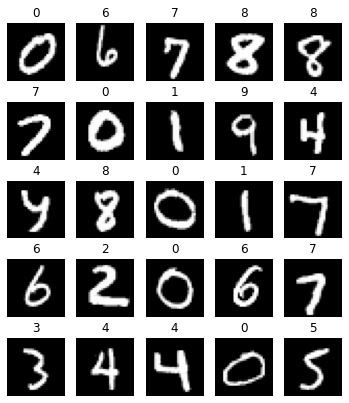

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)
#     forward_std.append(std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)
#     backward_std.append(std)


def make_linerar(in_dim, out_dim):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    return layer
    
    
# пример:
# layer = nn.Linear(28*28, 10)
# layer.register_forward_hook(forward_hook)
# layer.register_backward_hook(backward_hook)
# init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
# variant = "dumb"
variant = "xavier"

forward_std = []
bacward_std = []

sizes = [28**2] +  [200] * 20 + [10]
layers = []

for in_dim, out_dim in zip(sizes, sizes[1:]):
    layer = make_linerar(in_dim, out_dim)
    
    if variant == "dumb":
        init_layer(layer, 0, 0.1)
    elif variant == 'xavier':
#         init_layer(layer, 0, (2/(in_dim + out_dim))** 0.5)
        init_layer(layer, 0, (1/(out_dim))** 0.5)

    else:
        print('error')
        
    layers.append(nn.Tanh())
    layers.append(layer)
#     layers.append(nn.Sigmoid())

    

print(len(layers))

#пример:
# n_objects = 100
# X = images_train[:n_objects].view(n_objects, -1).data
# y = labels_train[:n_objects].data
# activations = network(X)
# loss_fn = torch.nn.NLLLoss()
# optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
# loss = loss_fn(activations, y)
# loss.backward()

42


In [8]:

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()



forward 0.48064202070236206
forward 0.6487521529197693
forward 0.5043262839317322
forward 0.4215976893901825
forward 0.37971067428588867
forward 0.34367355704307556
forward 0.31752169132232666
forward 0.29205867648124695
forward 0.28085291385650635
forward 0.26161184906959534
forward 0.2477981150150299
forward 0.24113675951957703
forward 0.2263195514678955
forward 0.21037431061267853
forward 0.2069770097732544
forward 0.2055446207523346
forward 0.19763484597206116
forward 0.19523829221725464
forward 0.19314780831336975
forward 0.1859855204820633
forward 0.1782924085855484
backward 0.03299831598997116
backward 0.09859631955623627
backward 0.09003746509552002
backward 0.08505932241678238
backward 0.07943721115589142
backward 0.07106078416109085
backward 0.06599787622690201
backward 0.061600785702466965
backward 0.058568667620420456
backward 0.05488193407654762
backward 0.053589046001434326
backward 0.046395912766456604
backward 0.04419847950339317
backward 0.036335140466690063
backward 0

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
sizes = [28**2] +  [200] * 20 + [10]
layers = []

def he(size_input, size_output):
    d = 2 / (size_input)
    return np.sqrt(d)

init_func = he
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

42


In [10]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9912435412406921
forward 0.7883511185646057
forward 0.8124825954437256
forward 0.8440297245979309
forward 0.9253517985343933
forward 0.9422974586486816
forward 0.9612133502960205
forward 0.9785214066505432
forward 0.867411196231842
forward 0.8790745139122009
forward 0.8605037331581116
forward 0.9020865559577942
forward 0.9183615446090698
forward 0.9186619520187378
forward 0.9050711989402771
forward 0.8313949108123779
forward 0.8494617938995361
forward 0.8421887755393982
forward 0.8219501376152039
forward 0.7182835936546326
forward 0.6961872577667236
backward 0.03299831598997116
backward 0.022272955626249313
backward 0.022050656378269196
backward 0.020815197378396988
backward 0.018378105014562607
backward 0.016387850046157837
backward 0.016206171363592148
backward 0.01791505143046379
backward 0.01599312573671341
backward 0.015590472146868706
backward 0.014364532195031643
backward 0.013827476650476456
backward 0.01093961764127016
backward 0.010296697728335857
backward 0.0100819

In [11]:
variant = "he"

sizes = [28**2] +  [200] * 20 + [10]
layers = []

for in_dim, out_dim in zip(sizes, sizes[1:]):
    layer = make_linerar(in_dim, out_dim)
    
    if variant == "dumb":
        init_layer(layer, 0, 0.1)
    elif variant == 'xavier':
#         init_layer(layer, 0, (2/(in_dim + out_dim))** 0.5)
        init_layer(layer, 0, (1/(out_dim))** 0.5)
    elif variant == 'he':
        init_layer(layer, 0, (2/(in_dim))**0.5)
    else:
        print('error')
    
    layers.append(layer)
    layers.append(nn.ReLU())

    

print(len(layers))
# del layers[-1]
#пример:
# n_objects = 100
# X = images_train[:n_objects].view(n_objects, -1).data
# y = labels_train[:n_objects].data
# activations = network(X)
# loss_fn = torch.nn.NLLLoss()
# optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
# loss = loss_fn(activations, y)
# loss.backward()

42


In [12]:

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9912435412406921
forward 0.8079401850700378
forward 0.8306067585945129
forward 0.8514695763587952
forward 0.8194907903671265
forward 0.8030831813812256
forward 0.7549538612365723
forward 0.831373393535614
forward 0.8424627184867859
forward 0.8837760090827942
forward 0.8929507732391357
forward 0.8716068863868713
forward 0.7953788042068481
forward 0.5956771969795227
forward 0.6179269552230835
forward 0.6356650590896606
forward 0.6555007696151733
forward 0.6675422191619873
forward 0.5916489362716675
forward 0.5636323094367981
forward 0.5821847915649414
backward 0.051088154315948486
backward 0.012775477021932602
backward 0.011731483973562717
backward 0.011630411259829998
backward 0.010730970650911331
backward 0.00978375319391489
backward 0.009269794449210167
backward 0.009288194589316845
backward 0.007303300779312849
backward 0.007059735246002674
backward 0.007539988495409489
backward 0.006811091210693121
backward 0.006901012267917395
backward 0.006287716329097748
backward 0.0058

<i> 1.4 Сделайте выводы по первой части </i>

Применение xavier и he позволило решиить проблему исчезающего градиента

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [13]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:
            mask = mask.bernoulli()

        mask = mask.detach()    
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

DropConnect().eval()

<i> 
2.2 Сравните графики обучения нейроных сетей:
    
    
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
    
    
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [14]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [15]:
mode = "none"

def get_layers(mode = "none", p = 0.5):
    layers = []
    sizes = [196, 128, 128, 10]
    for in_dim, out_dim in zip(sizes, sizes[1:]):
        if mode == "drop_connect":
            layer = DropConnect(in_dim, out_dim, p)
            layers.append(layer)
        else:
            layer = nn.Linear(in_dim, out_dim)
            layers.append(layer)
        if mode == "dropout":
            layers.append(nn.Dropout(p))
        layers.append(nn.ReLU())
    del layers[-1]
    return layers

In [16]:
layers = get_layers("none")

Epoch 9... (Train/Test) NLL: 0.045/0.059	Accuracy: 0.985/0.981


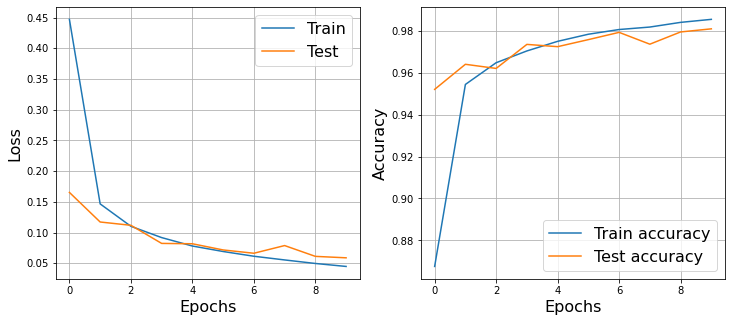

([0.447079091072718,
  0.14662610422541847,
  0.11015482498273285,
  0.0917779487877417,
  0.07803854317382486,
  0.06912032271554666,
  0.061395508483417634,
  0.05538570590372851,
  0.04963849383348754,
  0.04479108341753101],
 [0.1653338322722459,
  0.11715492716978622,
  0.11177133200572262,
  0.0823025089700388,
  0.08171727311431984,
  0.07164121576573086,
  0.06627391103383955,
  0.07879030776410541,
  0.06120219463010943,
  0.05884254970469901],
 [0.8675651,
  0.95438546,
  0.96475214,
  0.97037137,
  0.9749522,
  0.97834486,
  0.98058814,
  0.9817709,
  0.984003,
  0.9854411],
 [0.95203716,
  0.96400315,
  0.96202534,
  0.97349685,
  0.972409,
  0.97577137,
  0.9792326,
  0.97359574,
  0.9794304,
  0.98091376])

In [17]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [18]:
layers = get_layers("dropout", 0.2)
layers

[Linear(in_features=196, out_features=128, bias=True),
 Dropout(p=0.2, inplace=False),
 ReLU(),
 Linear(in_features=128, out_features=128, bias=True),
 Dropout(p=0.2, inplace=False),
 ReLU(),
 Linear(in_features=128, out_features=10, bias=True),
 Dropout(p=0.2, inplace=False)]

Epoch 9... (Train/Test) NLL: 0.257/0.056	Accuracy: 0.876/0.984


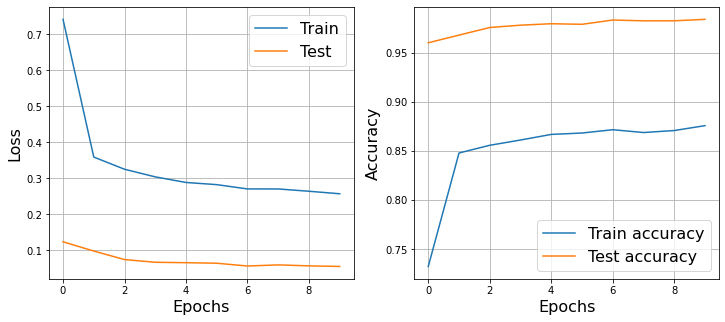

CPU times: user 4min 50s, sys: 5.3 s, total: 4min 55s
Wall time: 2min 56s


([0.7417519093830702,
  0.35930102971444,
  0.325446366310628,
  0.3043091247585028,
  0.2887257934252082,
  0.2827060873955806,
  0.2707567275174137,
  0.27073020758087446,
  0.26432922426889194,
  0.25738654477891126],
 [0.12399300239697288,
  0.0982732874683187,
  0.07462115175550497,
  0.06711188125235465,
  0.06594344210822749,
  0.06445107260082342,
  0.05669545947391351,
  0.059845816744845126,
  0.05712883919477463,
  0.05551680529348647],
 [0.73265374,
  0.84809214,
  0.8559435,
  0.8612851,
  0.8670043,
  0.86840904,
  0.87178504,
  0.86892545,
  0.87094665,
  0.8759217],
 [0.96024525,
  0.96805775,
  0.97577137,
  0.97814476,
  0.97962815,
  0.9790348,
  0.9833861,
  0.9825949,
  0.9825949,
  0.98407835])

In [19]:
%%time

from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [20]:
layers = get_layers("drop_connect", 0.8)
layers

[DropConnect(
   (linear): Linear(in_features=196, out_features=128, bias=True)
 ),
 ReLU(),
 DropConnect(
   (linear): Linear(in_features=128, out_features=128, bias=True)
 ),
 ReLU(),
 DropConnect(
   (linear): Linear(in_features=128, out_features=10, bias=True)
 )]

Epoch 9... (Train/Test) NLL: 0.070/0.050	Accuracy: 0.978/0.983


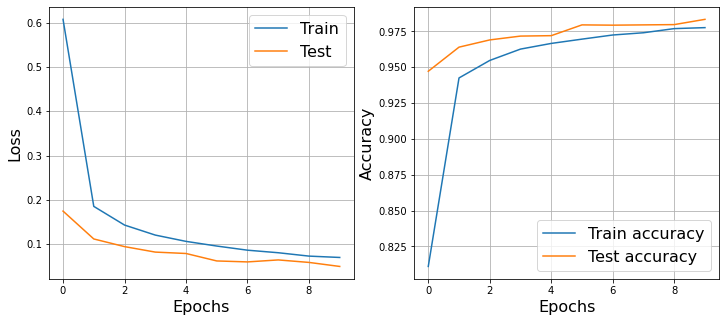

CPU times: user 4min 57s, sys: 5.66 s, total: 5min 2s
Wall time: 2min 59s


([0.6071975434512726,
  0.18524328569994805,
  0.14310836415491632,
  0.12049532136810359,
  0.10628315416385116,
  0.0957573848937366,
  0.0864006200416097,
  0.08066274608566817,
  0.0730490069101646,
  0.0699933318268341],
 [0.17457525736263282,
  0.11173588320424285,
  0.09447749897460395,
  0.08210137398041124,
  0.07895291846575617,
  0.06213066901988055,
  0.059961542245472156,
  0.06442884417085708,
  0.058807151568935644,
  0.049725703473639075],
 [0.81107295,
  0.94253063,
  0.9547353,
  0.96264774,
  0.96660113,
  0.969594,
  0.9724758,
  0.97404164,
  0.97692895,
  0.97761196],
 [0.9471915,
  0.96400315,
  0.96904665,
  0.97171676,
  0.9720135,
  0.97952926,
  0.9793315,
  0.97952926,
  0.979727,
  0.9833861])

In [21]:
%%time

from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

У dropout график точности на трейне находится ниже, чем на тесте. Это связано с тем, что у dropout зануляются сами нейроны, а у dropconnect - веса. Данные методы решают проблему переобучения

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [22]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(size).fill_(1.))
        self.betta = nn.Parameter(torch.FloatTensor(size).fill_(0.)) 
    
    def forward(self, x):
        output = ((x - x.mean(1, keepdim = True)) / x.std(1, keepdim = True) + 1e-6) *  self.gamma + self.betta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.020/0.067	Accuracy: 0.993/0.978


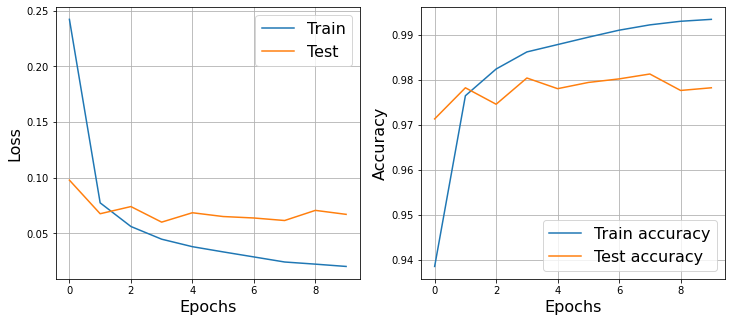

([0.24233001349037137,
  0.07728501848145716,
  0.05601980879322997,
  0.044594446107792826,
  0.03785680521474178,
  0.0331657966301004,
  0.028636330350695342,
  0.024078548397136124,
  0.022142571082010048,
  0.020076366945672264],
 [0.09770621749560666,
  0.06748187965182942,
  0.07393265658211481,
  0.059930620661972064,
  0.0683841129110631,
  0.0649746235790132,
  0.06365876725124772,
  0.061391330618835706,
  0.07051188729797737,
  0.06693370947673256],
 [0.938505,
  0.9764737,
  0.9824205,
  0.9862185,
  0.98785645,
  0.98949444,
  0.9910548,
  0.99223745,
  0.99303705,
  0.9934646],
 [0.9713212,
  0.97824365,
  0.97458464,
  0.9804193,
  0.9780459,
  0.9794304,
  0.9802215,
  0.98130935,
  0.97765034,
  0.97824365])

In [23]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(nn.BatchNorm1d(size_output))
    layers.append(nn.ReLU())

del layers[-2:]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.028/0.067	Accuracy: 0.991/0.980


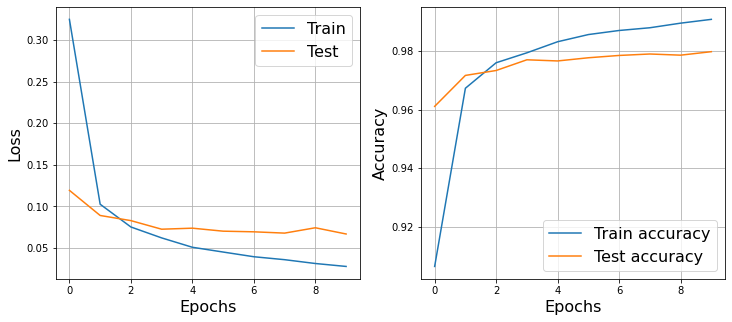

([0.32485943517165145,
  0.10255537116562506,
  0.07519056124966154,
  0.06207665855358881,
  0.05080442399835027,
  0.04506960782512371,
  0.0394229697508376,
  0.03588018057766611,
  0.03128603539630167,
  0.027750842598403918],
 [0.11925602826891066,
  0.08903844958713537,
  0.0828539431566679,
  0.07252676136897807,
  0.07376312024160465,
  0.07016610443191248,
  0.06939181018196329,
  0.06782947015017271,
  0.07426145390454161,
  0.06677195353763579],
 [0.9064277,
  0.96732855,
  0.9760461,
  0.9794443,
  0.9832256,
  0.98567986,
  0.98707354,
  0.9880064,
  0.9895778,
  0.9908771],
 [0.96113527,
  0.97171676,
  0.973398,
  0.977057,
  0.9766614,
  0.9777492,
  0.97854036,
  0.9790348,
  0.97863925,
  0.979826])

In [24]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(LayerNormalization(size_output))
    layers.append(nn.ReLU())

del layers[-2:]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')


<i> 3.3 Сделайте выводы по третьей части </i>

Layer Normalization улучшил качество на тесте 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: